In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_result(config:str,way_type:str,fault:str,speed:int,profile:str = "gost") ->pd.DataFrame:
    """
    Получение результатов расчетов по ключевым словам
    1. `config` принимает два вида строк `empty` и `loaded`
    2. `way_type` принимает три вида строк `straight`, `curve_350` и `curve_650`
    3. `fault` принимает три вида строк `normal`, `polzun15`, `ellips10`
    4. `speed` от 10 до 60 км/ч
    5. `profile` есть профили `gost`, `newlocow`, `greb_26`, `greb_30`, `greb_28`
    """
    if config == "empty":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\empty"
    
    elif config == "loaded":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\loaded"
    
    name = "\\"+config+"_"+way_type+"_"+fault+"_"+str(speed)+"_"+profile+".csv"

    FULL_PATH = PATH+name

    file = pd.read_csv(FULL_PATH,encoding='latin-1')

    COL_NAMES = ["time_step","Vertical_Force"]

    file.columns = COL_NAMES

    file = file.set_index("time_step")
    
    return file


In [3]:
def get_profile_results(config:str,way_type:str,fault:str,speed:int):
    file1 = get_result(config, way_type,fault,speed)
    file2 = get_result(config, way_type,fault,speed, "greb_26")
    file3 = get_result(config, way_type,fault,speed, "greb_28")
    file4 = get_result(config, way_type,fault,speed, "greb_30")
    file5 = get_result(config, way_type,fault,speed, "newlocow")

    return file1,file2,file3,file4,file5

In [4]:
def plot_profile_results(config:str,way_type:str,fault:str,speed:int):
    
    d={"loaded":"Груженый",
       "empty":"Порожний",
       "straight":"прямая",
       "curve_350":"кривая 350 м",
       "curve_650":"кривая 650 м",
       "normal":"без неисправностей",
       "polzun15":"ползун",
       "ellips10":"неравномерный прокат"}
    
   #  sns.set (rc={' axes.facecolor':'#C0C0C0', 'figure.facecolor':'#FFFFF0 '})
    
    files = get_profile_results(config, way_type,fault,speed)
    FILE = pd.concat(files,axis=1)
    FILE.columns = ["gost","greb_26","greb_28","greb_30","newlocow"]

    plt.figure(figsize=(12,8))
    sns.lineplot(FILE)
    plt.title(f"{d[config]} вагон, {d[way_type]}, {d[fault]} скорость {speed} км/ч ")
    plt.xlabel("Время, с")
    plt.ylabel("Вертикальная сила, Н")
    plt.show()



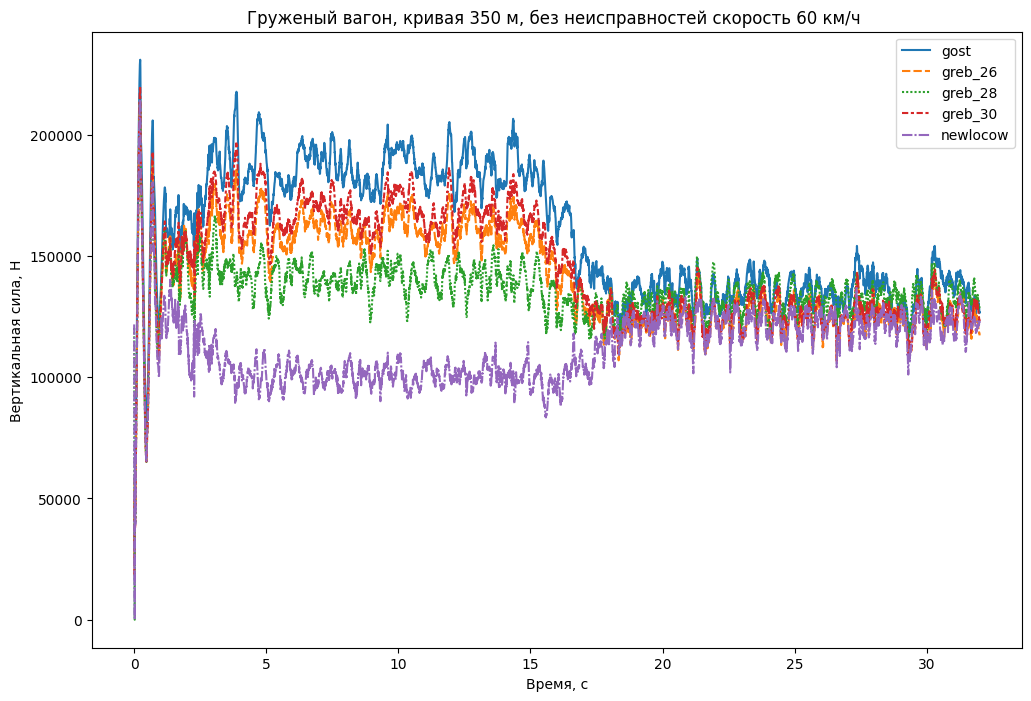

In [8]:
plot_profile_results("loaded","curve_350","normal",60)